<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Game-features-for-imitation-learning" data-toc-modified-id="Game-features-for-imitation-learning-1">Game features for imitation learning</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Study-game-size-distribution" data-toc-modified-id="Study-game-size-distribution-1.3">Study game size distribution</a></span></li><li><span><a href="#Input-features" data-toc-modified-id="Input-features-1.4">Input features</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#1d-features" data-toc-modified-id="1d-features-1.4.0.1">1d features</a></span></li><li><span><a href="#Board" data-toc-modified-id="Board-1.4.0.2">Board</a></span></li></ul></li></ul></li><li><span><a href="#Output-features-and-mask" data-toc-modified-id="Output-features-and-mask-1.5">Output features and mask</a></span></li></ul></li></ul></div>

# Game features for imitation learning

## Goal

On this notebook I'm going to implement the features needed to train an imitation learning model.

## Imports

In [1]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

In [20]:
import os
import glob
import random
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from kaggle_environments import make, evaluate
from functools import partial
from IPython.display import clear_output
from tqdm.notebook import tqdm
import json

from kaggle_environments.envs.lux_ai_2021.test_agents.python.lux.game import Game

from luxai.utils import render_game_in_html, set_random_seed
from luxai.input_features import make_input, CHANNELS_MAP, FEATURES_MAP
from luxai.output_features import (
    create_actions_mask, create_output_features,
    CITY_ACTIONS_MAP, UNIT_ACTIONS_MAP)

In [21]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## Study game size distribution

I have downloaded around 10k matches from the leaderboard. Let's see what is the distribution of the size of the board.

In [4]:
filepaths = glob.glob('/mnt/hdd0/Kaggle/luxai/matches_20211014/matches/*.json')

In [14]:
def get_board_size(filepath):
    with open(filepath, 'r') as f:
        match = json.load(f)
    return match[0][0]['observation']['height']

In [15]:
np.unique([get_board_size(filepath) for filepath in tqdm(filepaths)], return_counts=True)

  0%|          | 0/9430 [00:00<?, ?it/s]

(array([12, 16, 24, 32]), array([2225, 2326, 2457, 2422]))

The distribution seems to be uniform, so the size of the board is random.

## Input features

Let's create a function that given the observation creates the input features for the model. I will be using this [implementation](https://www.kaggle.com/shoheiazuma/lux-ai-with-imitation-learning) from the forum as a start point.

In [4]:
filepath  = '../data/sample_games/20210924_seed1_172steps.json'
with open(filepath, 'r') as f:
    match = json.load(f)

#### 1d features

In [5]:
board, features = make_input(match['steps'][70][0]['observation'])
for name, idx in FEATURES_MAP.items():
    print(name, features[idx])

step 0.19444445
is_night 1.0
is_last_day 0.0
player_research_points 0.32
opponent_research_points 0.14
is_player_in_coal_era 1.0
is_player_in_uranium_era 0.0
is_opponent_in_coal_era 0.0
is_opponent_in_uranium_era 0.0
player_n_cities 2.1
player_n_units 0.9
opponent_n_cities 0.9
opponent_n_units 0.9


These features look good.

#### Board

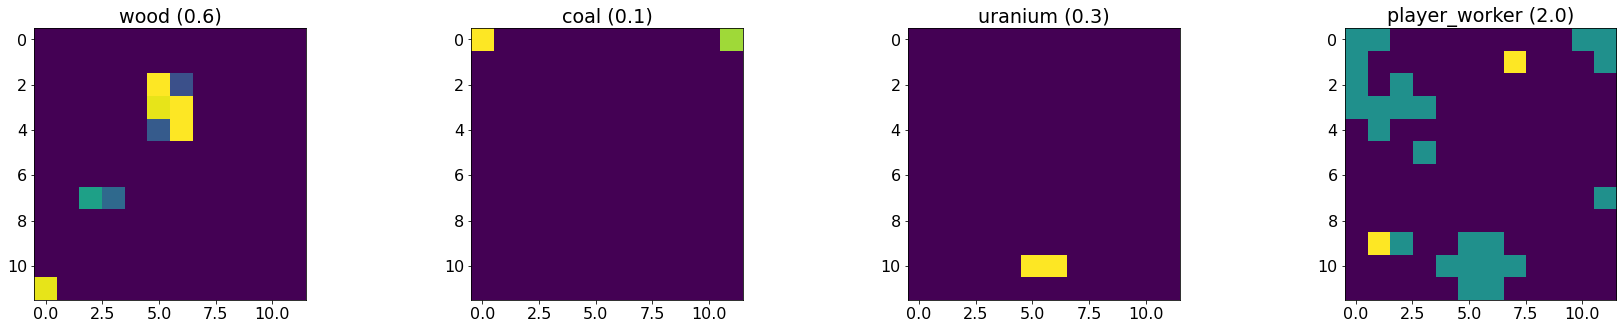

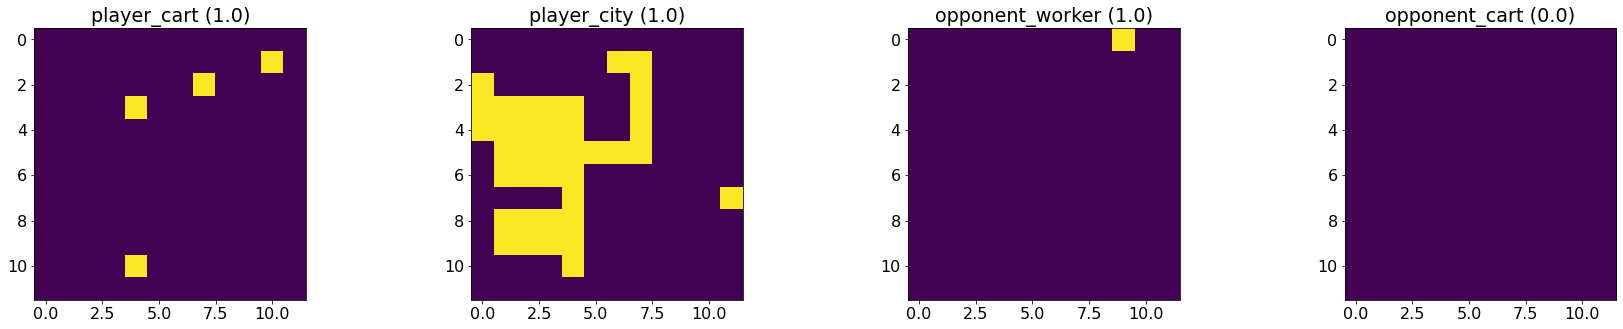

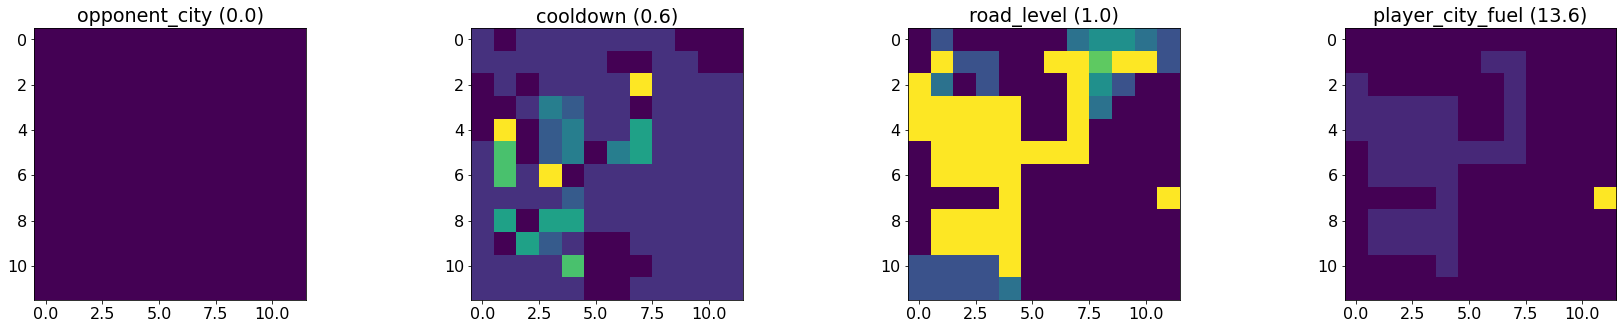

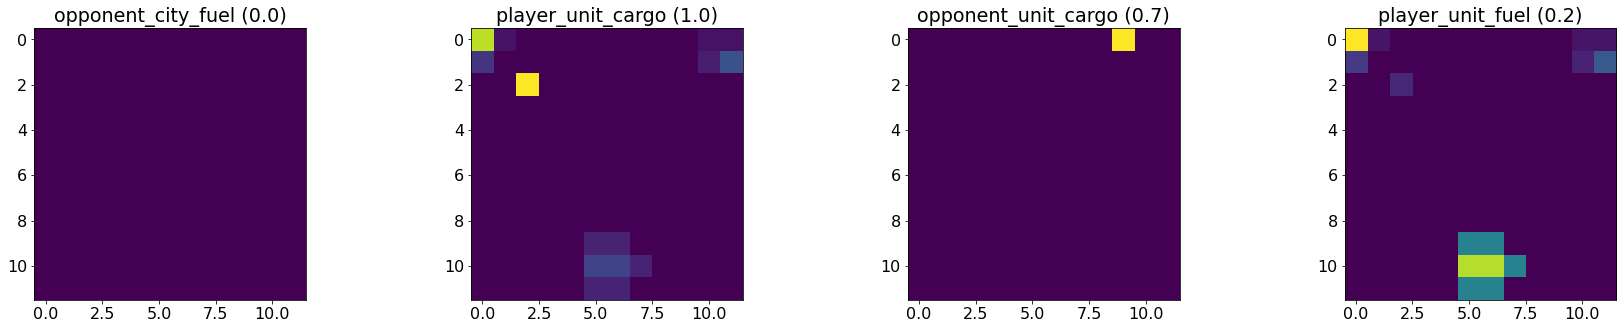

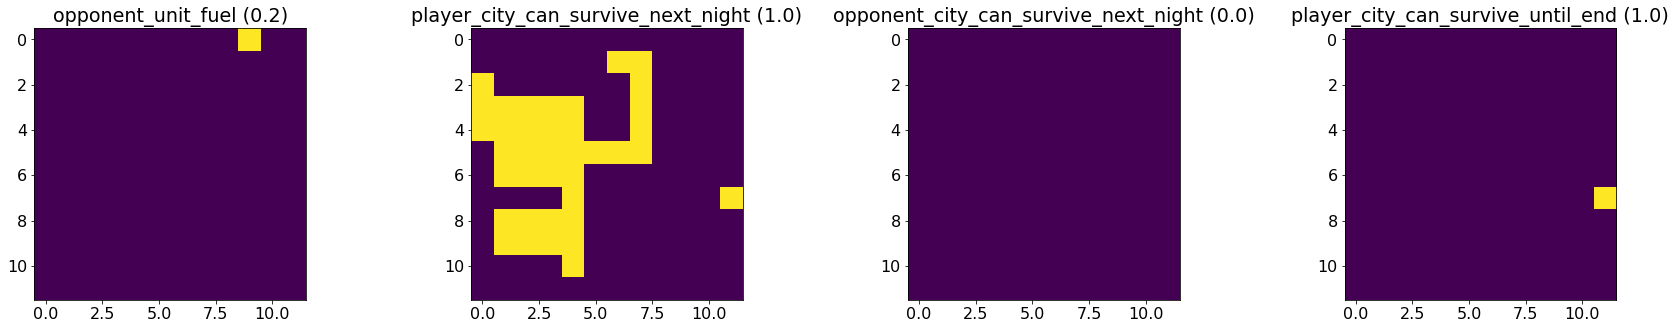

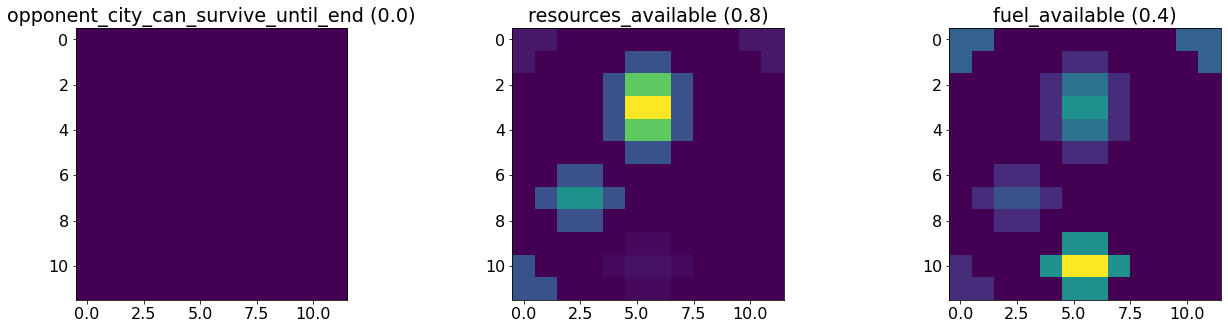

In [12]:
board, features = make_input(match['steps'][150][0]['observation'])
n_cols = 4
for name, idx in CHANNELS_MAP.items():
    if idx % n_cols == 0:
        plt.show()
    plt.subplot(1, n_cols, idx % n_cols + 1)
    plt.imshow(np.transpose(board[idx]))
    plt.title('%s (%.1f)' % (name, np.max(board[idx])))

TODO: visualize the board and features to verify everything is fine

## Output features and mask

To ease learning I think we should better create a different output and mask for unit and cities.

To create the mask I need to know the location of the active units or cities, that information should better be created when parsing the observation for the input features.

To create the output for the units I need to know the location of all the units (because I might transfer resources from an active unit to a non active unit).

In [45]:
step = 53
observation = match['steps'][step][0]['observation']
actions = match['steps'][step+1][0]['action'] # notice the step + 150

ret = make_input(observation)
active_units_to_position, active_cities_to_position, units_to_position = ret[2:]
unit_actions_mask = create_actions_mask(active_units_to_position, observation)
city_actions_mask = create_actions_mask(active_cities_to_position, observation)
unit_actions, city_actions = create_output_features(actions, units_to_position, observation)

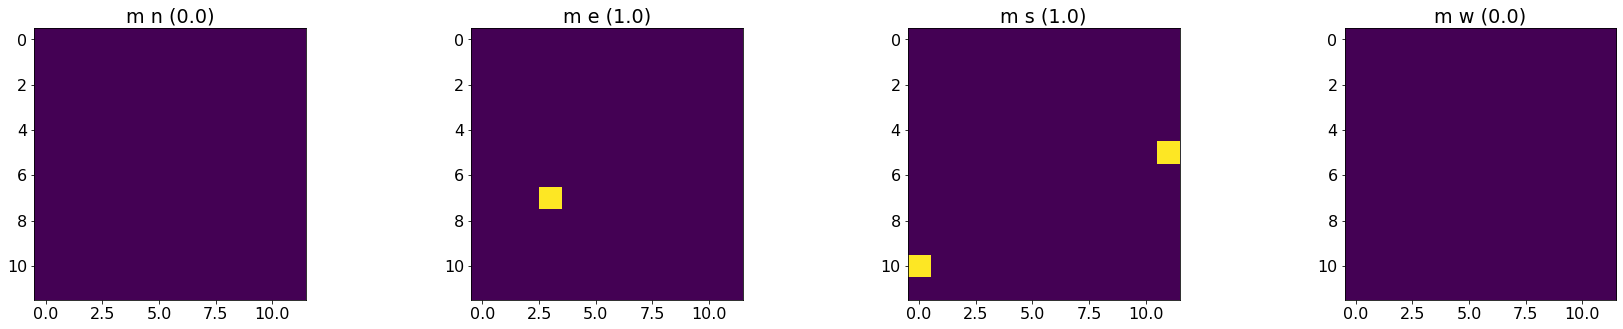

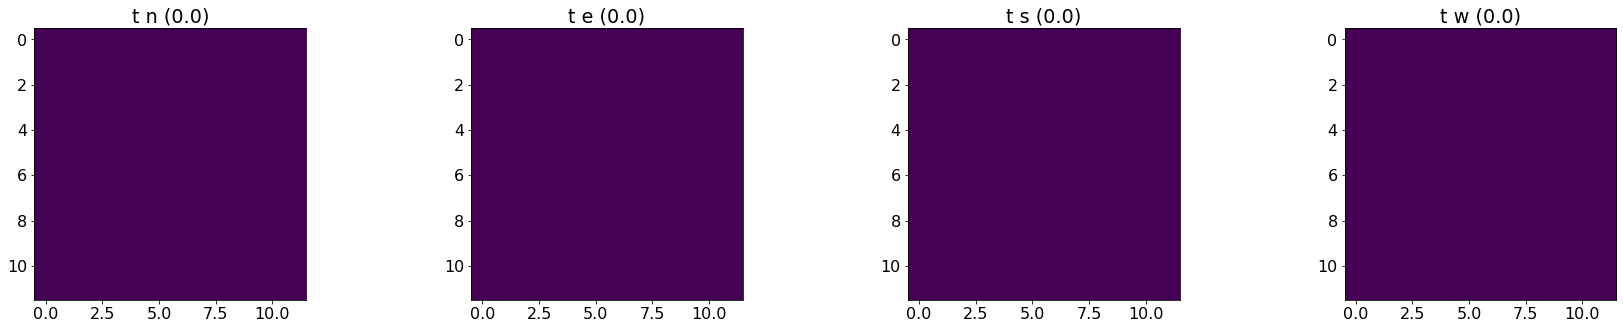

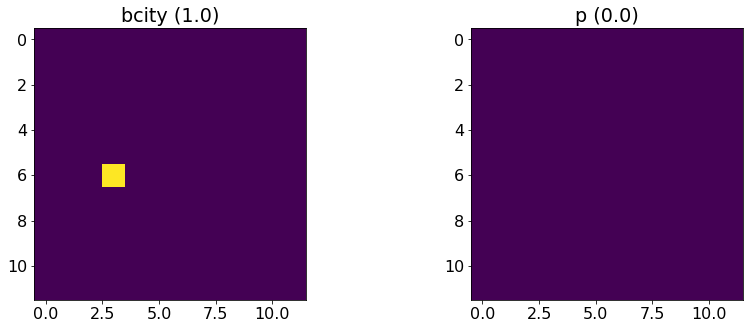

In [46]:
n_cols = 4
for name, idx in UNIT_ACTIONS_MAP.items():
    if idx % n_cols == 0:
        plt.show()
    plt.subplot(1, n_cols, idx % n_cols + 1)
    plt.imshow(np.transpose(unit_actions[idx]))
    plt.title('%s (%.1f)' % (name, np.max(unit_actions[idx])))

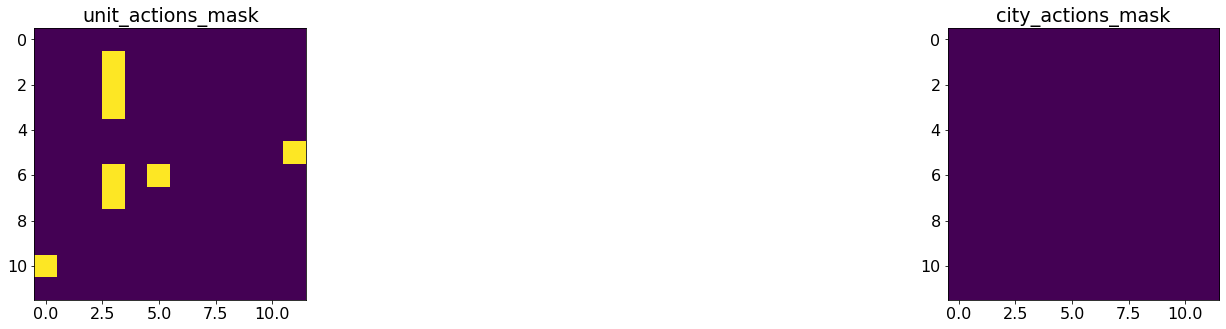

In [47]:
plt.subplot(121)
plt.title('unit_actions_mask')
plt.imshow(np.transpose(unit_actions_mask[:, :, 0]))
plt.subplot(122)
plt.title('city_actions_mask')
plt.imshow(np.transpose(city_actions_mask[:, :, 0]));

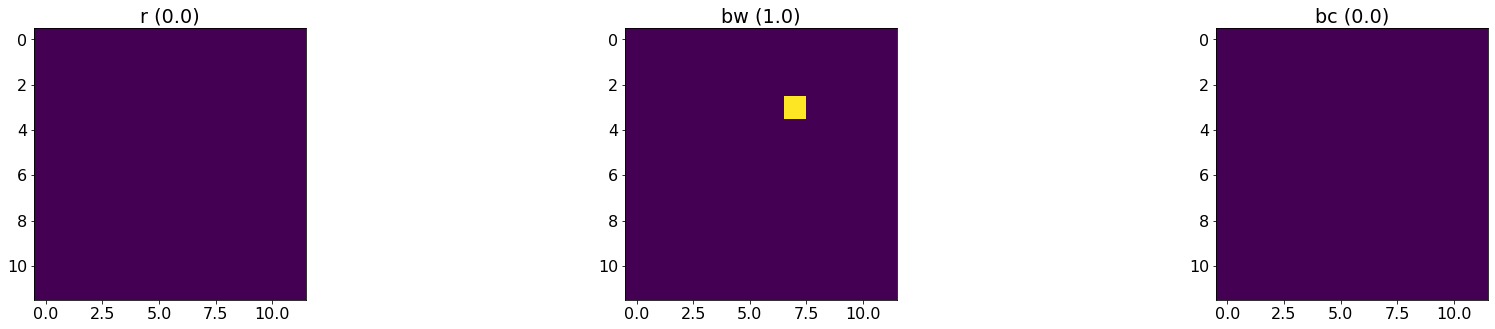

In [19]:
n_cols = 3
for name, idx in CITY_ACTIONS_MAP.items():
    if idx % n_cols == 0:
        plt.show()
    plt.subplot(1, n_cols, idx % n_cols + 1)
    plt.imshow(np.transpose(city_actions[idx]))
    plt.title('%s (%.1f)' % (name, np.max(city_actions[idx])))